## Introduction

Text Summarization is one of those applications of Natural Language Processing (NLP) which is bound to have a huge impact on our lives. With growing digital media and ever growing publishing – who has the time to go through entire articles / documents / books to decide whether they are useful or not? Thankfully – this technology is already here.

Have you come across the mobile app inshorts? It’s an innovative news app that converts news articles into a 60-word summary. And that is exactly what we are going to learn in this article — Automatic Text Summarization.

Automatic Text Summarization is one of the most challenging and interesting problems in the field of Natural Language Processing (NLP). It is a process of generating a concise and meaningful summary of text from multiple text resources such as books, news articles, blog posts, research papers, emails, and tweets.

The demand for automatic text summarization systems is spiking these days thanks to the availability of large amounts of textual data.

Through this article, we will explore the realms of text summarization. We will understand how the TextRank algorithm works, and will also implement it in Python. Strap in, this is going to be a fun ride!

## Understanding the TextRank Algorithm

Before getting started with the TextRank algorithm, there’s another algorithm which we should become familiar with – the PageRank algorithm. In fact, this actually inspired TextRank! PageRank is used primarily for ranking web pages in online search results. Let’s quickly understand the basics of this algorithm with the help of an example.

![](https://cdn.analyticsvidhya.com/wp-content/uploads/2018/10/Pagerank11.png)


## TextRank Algorithm

Let’s understand the TextRank algorithm, now that we have a grasp on PageRank. I have listed the similarities between these two algorithms below:

In place of web pages, we use sentences
Similarity between any two sentences is used as an equivalent to the web page transition probability
The similarity scores are stored in a square matrix, similar to the matrix M used for PageRank
TextRank is an extractive and unsupervised text summarization technique. Let’s take a look at the flow of the TextRank algorithm that we will be following:

![](https://cdn.analyticsvidhya.com/wp-content/uploads/2018/10/block_3.png)




 

 


# 1 Importing the required Libraries

In [1]:
import numpy as np
import pandas as pd
import warnings
import re
import nltk
from nltk import word_tokenize
from nltk.tokenize import sent_tokenize
from textblob import TextBlob
import string
from string import punctuation
from nltk.corpus import stopwords
from statistics import mean
from heapq import nlargest
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt

stop_words = set(stopwords.words('english'))
punctuation = punctuation + '\n' + '—' + '“' + ',' + '”' + '‘' + '-' + '’'
warnings.filterwarnings('ignore')

In [2]:
# Importing the dataset
df_1 = pd.read_csv("/kaggle/input/all-the-news/articles1.csv")
df_2 = pd.read_csv("/kaggle/input/all-the-news/articles2.csv")
df_3 = pd.read_csv("/kaggle/input/all-the-news/articles3.csv")

In [3]:
# Checking if the columns are same or not
df_1.columns == df_2.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [4]:
# Checking if the columns are same or not
df_2.columns == df_3.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [5]:
# Making one Dataframe by appending all of them for the further process
d = [df_1, df_2, df_3]
df = pd.concat(d, keys = ['x', 'y', 'z'])
df.rename(columns = {'content' : 'article'}, inplace = True);

In [6]:
df.head()

Unnamed: 0     id                                              title  \
x 0           0  17283  House Republicans Fret About Winning Their Hea...   
  1           1  17284  Rift Between Officers and Residents as Killing...   
  2           2  17285  Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...   
  3           3  17286  Among Deaths in 2016, a Heavy Toll in Pop Musi...   
  4           4  17287  Kim Jong-un Says North Korea Is Preparing to T...   

        publication                         author        date    year  month  \
x 0  New York Times                     Carl Hulse  2016-12-31  2016.0   12.0   
  1  New York Times  Benjamin Mueller and Al Baker  2017-06-19  2017.0    6.0   
  2  New York Times                   Margalit Fox  2017-01-06  2017.0    1.0   
  3  New York Times               William McDonald  2017-04-10  2017.0    4.0   
  4  New York Times                  Choe Sang-Hun  2017-01-02  2017.0    1.0   

     url                                            article  
x 0  NaN  WASHINGTON  —   Congressional Republicans have...  
  1  NaN  After the bullet shells get counted, the blood...  
  2  NaN  When Walt Disney’s “Bambi” opened in 1942, cri...  
  3  NaN  Death may be the great equalizer, but it isn’t...  
  4  NaN  SEOUL, South Korea  —   North Korea’s leader, ...

In [7]:
# Shape of the dataset
print ("The shape of the dataset : ", df.shape)

The shape of the dataset :  (142570, 10)


In [8]:
# Dropping the unnecessary columns
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head()

id                                              title     publication  \
x 0  17283  House Republicans Fret About Winning Their Hea...  New York Times   
  1  17284  Rift Between Officers and Residents as Killing...  New York Times   
  2  17285  Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...  New York Times   
  3  17286  Among Deaths in 2016, a Heavy Toll in Pop Musi...  New York Times   
  4  17287  Kim Jong-un Says North Korea Is Preparing to T...  New York Times   

                            author        date    year  month  url  \
x 0                     Carl Hulse  2016-12-31  2016.0   12.0  NaN   
  1  Benjamin Mueller and Al Baker  2017-06-19  2017.0    6.0  NaN   
  2                   Margalit Fox  2017-01-06  2017.0    1.0  NaN   
  3               William McDonald  2017-04-10  2017.0    4.0  NaN   
  4                  Choe Sang-Hun  2017-01-02  2017.0    1.0  NaN   

                                               article  
x 0  WASHINGTON  —   Congressional Republicans have...  
  1  After the bullet shells get counted, the blood...  
  2  When Walt Disney’s “Bambi” opened in 1942, cri...  
  3  Death may be the great equalizer, but it isn’t...  
  4  SEOUL, South Korea  —   North Korea’s leader, ...

[Text(0.5, 0, 'Publication'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Distribution of Publication according')]

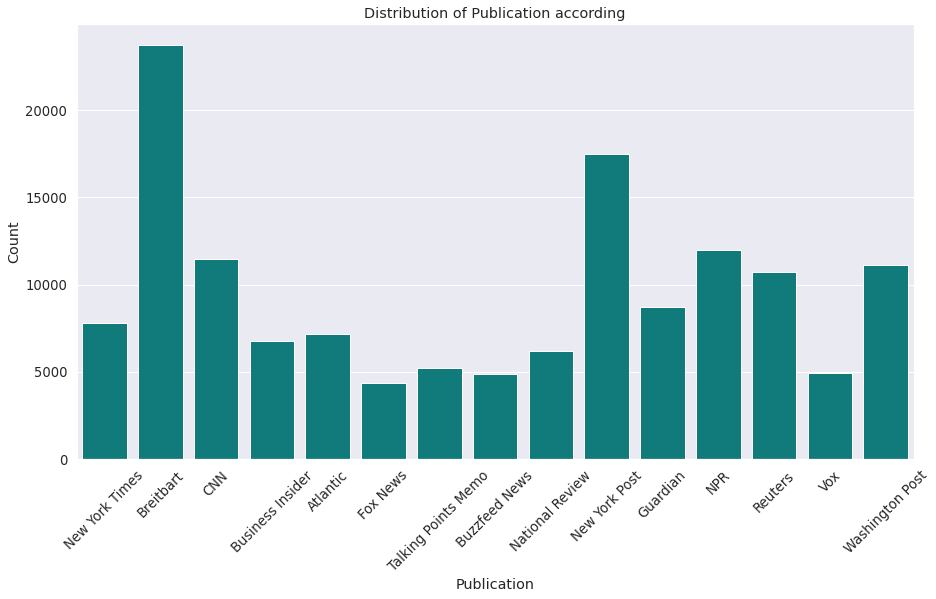

In [9]:
# Countplot shows the distribution of Publication
plt.rcParams['figure.figsize'] = [15, 8]
sns.set(font_scale = 1.2, style = 'darkgrid')
sns_year = sns.countplot(df['publication'], color = 'darkcyan')
plt.xticks(rotation=45)
sns_year.set(xlabel = "Publication", ylabel = "Count", title = "Distribution of Publication according")

# 2 Exploratory Data Analysis

In [10]:
# Replacing the unnecessary row value of year with it's actual values
df['year'] = df['year'].replace("https://www.washingtonpost.com/outlook/tale-of-a-woman-who-died-and-a-woman-who-killed-in-the-northern-ireland-conflict/2019/03/08/59e75dd4-2ecd-11e9-8ad3-9a5b113ecd3c_story.html", 2019)

In [11]:
# Years
df['year'].value_counts()

2016.0    85405
2017.0    50404
2015.0     3705
2013.0      228
2014.0      125
2012.0       34
2011.0        8
2010.0        6
2008.0        3
2009.0        3
2004.0        2
2003.0        2
2005.0        2
2007.0        1
2000.0        1
Name: year, dtype: int64

[Text(0.5, 0, 'Year'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Distribution of the articles according to the year')]

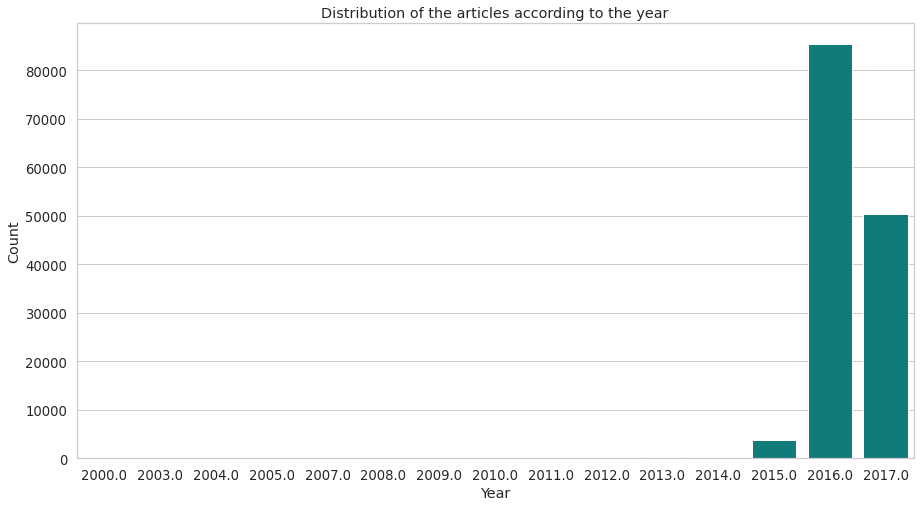

In [12]:
# Countplot shows the distribution of the articles according to the year
plt.rcParams['figure.figsize'] = [15, 8]
sns.set(font_scale = 1.2, style = 'whitegrid')
sns_year = sns.countplot(df['year'], color = 'darkcyan')
sns_year.set(xlabel = "Year", ylabel = "Count", title = "Distribution of the articles according to the year")

In [13]:
# Authors
df['author'].value_counts()

Breitbart News                         1559
Pam Key                                1282
Associated Press                       1231
Charlie Spiering                        928
Jerome Hudson                           806
                                       ... 
Catherine Evans                           1
Roberta Rampton and Noah Barkin           1
Yamiche Alcindor and Colin Moynihan       1
Bo Dietl                                  1
Brett Anderson                            1
Name: author, Length: 15647, dtype: int64

[Text(0.5, 21.200000000000003, 'count'),
 Text(21.200000000000003, 0.5, 'author'),
 Text(0.5, 1.0, 'the most freq author')]

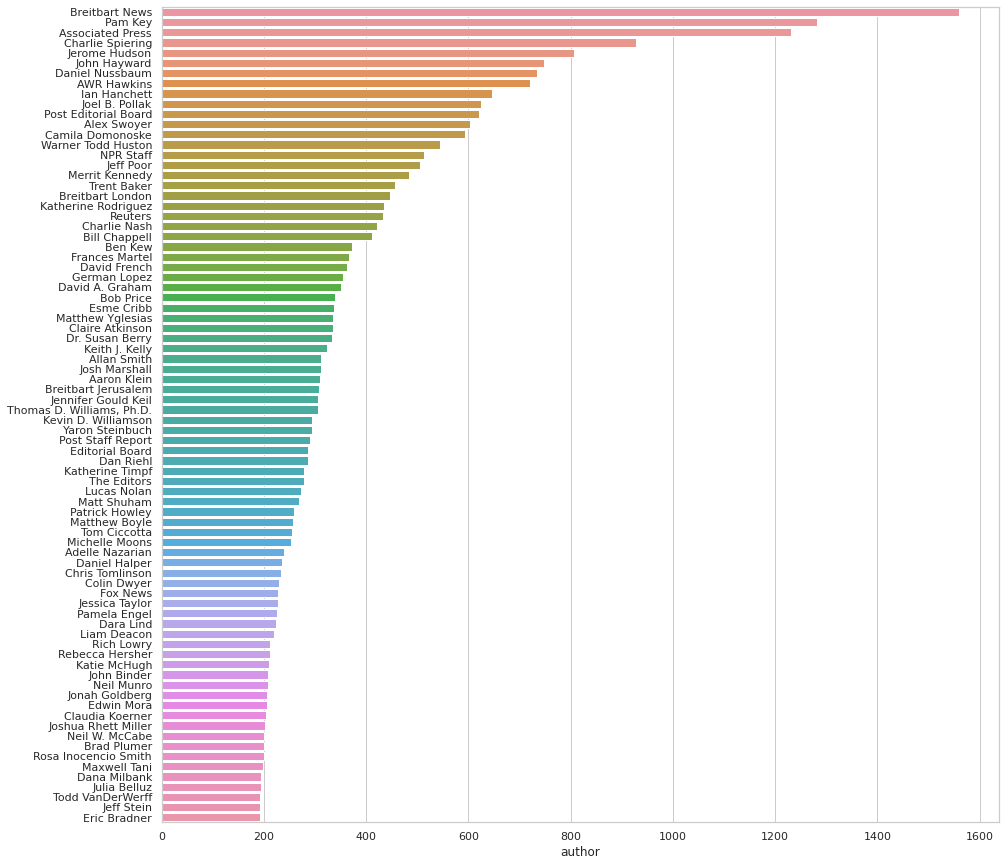

In [14]:
# Countplot shows the distribution of author
plt.rcParams['figure.figsize'] = [15, 15]
sns.set(font_scale = 1, style = 'whitegrid')
df_author = df.author.value_counts().head(80)

sns.barplot(df_author,df_author.index)
sns_year.set(xlabel = "count", ylabel = "author", title = "the most freq author")

In [15]:
# Changing the value "The Associated Press" to "Associated Press"
df['author'] = df['author'].replace("The Associated Press", "Associated Press")

# 3 Making the Article Summarizer

In [16]:
contractions_dict = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"doesn’t": "does not",
"don't": "do not",
"don’t": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so is",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y’all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have",
"ain’t": "am not",
"aren’t": "are not",
"can’t": "cannot",
"can’t’ve": "cannot have",
"’cause": "because",
"could’ve": "could have",
"couldn’t": "could not",
"couldn’t’ve": "could not have",
"didn’t": "did not",
"doesn’t": "does not",
"don’t": "do not",
"don’t": "do not",
"hadn’t": "had not",
"hadn’t’ve": "had not have",
"hasn’t": "has not",
"haven’t": "have not",
"he’d": "he had",
"he’d’ve": "he would have",
"he’ll": "he will",
"he’ll’ve": "he will have",
"he’s": "he is",
"how’d": "how did",
"how’d’y": "how do you",
"how’ll": "how will",
"how’s": "how is",
"i’d": "i would",
"i’d’ve": "i would have",
"i’ll": "i will",
"i’ll’ve": "i will have",
"i’m": "i am",
"i’ve": "i have",
"isn’t": "is not",
"it’d": "it would",
"it’d’ve": "it would have",
"it’ll": "it will",
"it’ll’ve": "it will have",
"it’s": "it is",
"let’s": "let us",
"ma’am": "madam",
"mayn’t": "may not",
"might’ve": "might have",
"mightn’t": "might not",
"mightn’t’ve": "might not have",
"must’ve": "must have",
"mustn’t": "must not",
"mustn’t’ve": "must not have",
"needn’t": "need not",
"needn’t’ve": "need not have",
"o’clock": "of the clock",
"oughtn’t": "ought not",
"oughtn’t’ve": "ought not have",
"shan’t": "shall not",
"sha’n’t": "shall not",
"shan’t’ve": "shall not have",
"she’d": "she would",
"she’d’ve": "she would have",
"she’ll": "she will",
"she’ll’ve": "she will have",
"she’s": "she is",
"should’ve": "should have",
"shouldn’t": "should not",
"shouldn’t’ve": "should not have",
"so’ve": "so have",
"so’s": "so is",
"that’d": "that would",
"that’d’ve": "that would have",
"that’s": "that is",
"there’d": "there would",
"there’d’ve": "there would have",
"there’s": "there is",
"they’d": "they would",
"they’d’ve": "they would have",
"they’ll": "they will",
"they’ll’ve": "they will have",
"they’re": "they are",
"they’ve": "they have",
"to’ve": "to have",
"wasn’t": "was not",
"we’d": "we would",
"we’d’ve": "we would have",
"we’ll": "we will",
"we’ll’ve": "we will have",
"we’re": "we are",
"we’ve": "we have",
"weren’t": "were not",
"what’ll": "what will",
"what’ll’ve": "what will have",
"what’re": "what are",
"what’s": "what is",
"what’ve": "what have",
"when’s": "when is",
"when’ve": "when have",
"where’d": "where did",
"where’s": "where is",
"where’ve": "where have",
"who’ll": "who will",
"who’ll’ve": "who will have",
"who’s": "who is",
"who’ve": "who have",
"why’s": "why is",
"why’ve": "why have",
"will’ve": "will have",
"won’t": "will not",
"won’t’ve": "will not have",
"would’ve": "would have",
"wouldn’t": "would not",
"wouldn’t’ve": "would not have",
"y’all": "you all",
"y’all": "you all",
"y’all’d": "you all would",
"y’all’d’ve": "you all would have",
"y’all’re": "you all are",
"y’all’ve": "you all have",
"you’d": "you would",
"you’d’ve": "you would have",
"you’ll": "you will",
"you’ll’ve": "you will have",
"you’re": "you are",
"you’re": "you are",
"you’ve": "you have",
}
contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))
# Function to clean the html from the article
def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext

# Function expand the contractions if there's any
def expand_contractions(s, contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, s)

# Function to preprocess the articles
def preprocessing(article):
    global article_sent
    
    # Converting to lowercase
    article = article.str.lower()
    
    # Removing the HTML
    article = article.apply(lambda x: cleanhtml(x))
    
    # Removing the email ids
    article = article.apply(lambda x: re.sub('\S+@\S+','', x))
    
    # Removing The URLS
    article = article.apply(lambda x: re.sub("((http\://|https\://|ftp\://)|(www.))+(([a-zA-Z0-9\.-]+\.[a-zA-Z]{2,4})|([0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}))(/[a-zA-Z0-9%:/-_\?\.'~]*)?",'', x))
    
    # Removing the '\xa0'
    article = article.apply(lambda x: x.replace("\xa0", " "))
    
    # Removing the contractions
    article = article.apply(lambda x: expand_contractions(x))
    
    # Stripping the possessives
    article = article.apply(lambda x: x.replace("'s", ''))
    article = article.apply(lambda x: x.replace('’s', ''))
    article = article.apply(lambda x: x.replace("\'s", ''))
    article = article.apply(lambda x: x.replace("\’s", ''))
    
    # Removing the Trailing and leading whitespace and double spaces
    article = article.apply(lambda x: re.sub(' +', ' ',x))
    
    # Copying the article for the sentence tokenization
    article_sent = article.copy()
    
    # Removing punctuations from the article
    article = article.apply(lambda x: ''.join(word for word in x if word not in punctuation))
    
    # Removing the Trailing and leading whitespace and double spaces again as removing punctuation might
    # Lead to a white space
    article = article.apply(lambda x: re.sub(' +', ' ',x))
    
    # Removing the Stopwords
    article = article.apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))
    
    return article

# Function to normalize the word frequency which is used in the function word_frequency
def normalize(li_word):
    global normalized_freq
    normalized_freq = []
    for dictionary in li_word:
        max_frequency = max(dictionary.values())
        for word in dictionary.keys():
            dictionary[word] = dictionary[word]/max_frequency
        normalized_freq.append(dictionary)
    return normalized_freq

# Function to calculate the word frequency
def word_frequency(article_word):
    word_frequency = {}
    li_word = []
    for sentence in article_word:
        for word in word_tokenize(sentence):
            if word not in word_frequency.keys():
                word_frequency[word] = 1
            else:
                word_frequency[word] += 1
        li_word.append(word_frequency)
        word_frequency = {}
    normalize(li_word)
    return normalized_freq

# Function to Score the sentence which is called in the function sent_token
def sentence_score(li):
    global sentence_score_list
    sentence_score = {}
    sentence_score_list = []
    for list_, dictionary in zip(li, normalized_freq):
        for sent in list_:
            for word in word_tokenize(sent):
                if word in dictionary.keys():
                    if sent not in sentence_score.keys():
                        sentence_score[sent] = dictionary[word]
                    else:
                        sentence_score[sent] += dictionary[word]
        sentence_score_list.append(sentence_score)
        sentence_score = {}
    return sentence_score_list

# Function to tokenize the sentence
def sent_token(article_sent):
    sentence_list = []
    sent_token = []
    for sent in article_sent:
        token = sent_tokenize(sent)
        for sentence in token:
            token_2 = ''.join(word for word in sentence if word not in punctuation)
            token_2 = re.sub(' +', ' ',token_2)
            sent_token.append(token_2)
        sentence_list.append(sent_token)
        sent_token = []
    sentence_score(sentence_list)
    return sentence_score_list

# Function which generates the summary of the articles (This uses the 20% of the sentences with the highest score)
def summary(sentence_score_OwO):
    summary_list = []
    for summ in sentence_score_OwO:
        select_length = int(len(summ)*0.25)
        summary_ = nlargest(select_length, summ, key = summ.get)
        summary_list.append(".".join(summary_))
    return summary_list


# Functions to change the article string (if passed) to change it to generate a pandas series
def make_series(art):
    global dataframe
    data_dict = {'article' : [art]}
    dataframe = pd.DataFrame(data_dict)['article']
    return dataframe

# Function which is to be called to generate the summary which in further calls other functions alltogether
def article_summarize(artefact):
    
    if type(artefact) != pd.Series:
        artefact = make_series(artefact)
    
    df = preprocessing(artefact)
    
    word_normalization = word_frequency(df)
    
    sentence_score_OwO = sent_token(article_sent)
    
    summarized_article = summary(sentence_score_OwO)
    
    return summarized_article

In [17]:
# Generating the Word Cloud of the article using the preprocessing and make_series function mentioned below
def word_cloud(art):
    art_ = make_series(art)
    OwO = preprocessing(art_)
    wordcloud_ = WordCloud(height = 500, width = 1000, background_color = 'white').generate(art)
    plt.figure(figsize=(15, 10))
    plt.imshow(wordcloud_, interpolation='bilinear')
    plt.axis('off');
# Generating the summaries for the first 100 articles
summaries = article_summarize(df['article'][0:100])

In [18]:
print ("The Actual length of the article is : ", len(df['article'][0]))
df['article'][0]

The Actual length of the article is :  5607


'WASHINGTON  —   Congressional Republicans have a new fear when it comes to their    health care lawsuit against the Obama administration: They might win. The incoming Trump administration could choose to no longer defend the executive branch against the suit, which challenges the administration’s authority to spend billions of dollars on health insurance subsidies for   and   Americans, handing House Republicans a big victory on    issues. But a sudden loss of the disputed subsidies could conceivably cause the health care program to implode, leaving millions of people without access to health insurance before Republicans have prepared a replacement. That could lead to chaos in the insurance market and spur a political backlash just as Republicans gain full control of the government. To stave off that outcome, Republicans could find themselves in the awkward position of appropriating huge sums to temporarily prop up the Obama health care law, angering conservative voters who have been 

In [19]:
print ("The length of the summarized article is : ", len(summaries[0]))
summaries[0]

The length of the summarized article is :  1682


'anticipating that the trump administration might not be inclined to mount a vigorous fight against the house republicans given the dim view of the health care law a team of lawyers this month sought to intervene in the case on behalf of two participants in the health care program.the incoming trump administration could choose to no longer defend the executive branch against the suit which challenges the administration authority to spend billions of dollars on health insurance subsidies for and americans handing house republicans a big victory on issues. in a potentially decision in 2015 judge rosemary m collyer ruled that house republicans had the standing to sue the executive branch over a spending dispute and that the obama administration had been distributing the health insurance subsidies in violation of the constitution without approval from congress.in their request the lawyers predicted that a deal between house republicans and the new administration to dismiss or settle the ca